In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [5]:
filename = "results-eval/17-sk-en-results.csv"
with open("speech/2_sk_en.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

["So we've got 1,000.", 'Uh.', "He's actually 1 to 2 minutes to get acquainted with this site.", 'So we see a headline on the page.', 'Any stats a day?', 'The vaccine is sie.', 'Any different tables?', 'Current metals for the vending machine.', 'Also highlighting for individual districts.', 'How can we prevent infection that we should not be seeing other people, not family or friends?', 'Granite 2m from other people.', "What are we supposed to do when we're positive?", 'It works a lot.', 'Cn.', 'What are we supposed to do if we were?', 'Hm close to some qualities positive, i.e.', 'in contact with him.', "So we're supposed to describe some of our impressions?", 'Uh, the website.', "Uh, isn't it?", 'Website on 1.', 'View.', 'It looks pretty neat.', 'Although.', 'Quite a lot.', 'Uh those lines uh is pointing to the Slovak version of this site, which is quite strange since we are on.', 'The English version.', "Well, there's all the important information I think.", 'A metal house.', 'Hmm it

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['So we have got 1000', 'Uh', 'he has he is actually 1 to 2 minutes to get acquainted with this site', 'So we see a headline on the page', 'Any stats a day', 'The vaccine is sie', 'Any different tables', 'Current metals for the vending machine', 'Also highlighting for individual districts', 'How can we prevent infection that we should not be seeing other people not family or friends', 'Granite 2m from other people', 'What are we supposed to do when we are positive', 'It works a lot', 'Cn', 'What are we supposed to do if we were', 'Hm close to some qualities positive ie', 'in contact with him', 'So we are supposed to describe some of our impressions', 'Uh the website', 'Uh is not it', 'Website on 1', 'View', 'It looks pretty neat', 'Although', 'Quite a lot', 'Uh those lines uh is pointing to the Slovak version of this site which is quite strange since we are on', 'The English version', 'Well there has there is all the important information I think', 'A metal house', 'Hmm it so into the 

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('So', None), ('we', None), ('have', 'v'), ('got', 'v'), ('1000', None)], [('Uh', 'n')], [('he', None), ('has', 'v'), ('he', None), ('is', 'v'), ('actually', 'r'), ('1', None), ('to', None), ('2', None), ('minutes', 'n'), ('to', None), ('get', 'v'), ('acquainted', 'v'), ('with', None), ('this', None), ('site', 'n')], [('So', None), ('we', None), ('see', 'v'), ('a', None), ('headline', 'n'), ('on', None), ('the', None), ('page', 'n')], [('Any', None), ('stats', 'n'), ('a', None), ('day', 'n')], [('The', None), ('vaccine', 'n'), ('is', 'v'), ('sie', 'a')], [('Any', None), ('different', 'a'), ('tables', 'n')], [('Current', 'a'), ('metals', 'n'), ('for', None), ('the', None), ('vending', 'n'), ('machine', 'n')], [('Also', 'r'), ('highlighting', 'v'), ('for', None), ('individual', 'a'), ('districts', 'n')], [('How', None), ('can', None), ('we', None), ('prevent', 'v'), ('infection', 'n'), ('that', None), ('we', None), ('should', None), ('not', 'r'), ('be', 'v'), ('seeing', 'v'), ('other',

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            if word.lower() == "like":
                lemmatized_sentence.append(word + '-(NON-STANDARD)')
            else:
                lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['So', 'we', 'have', 'get', '1000'], ['Uh'], ['he', 'have', 'he', 'be', 'actually', '1', 'to', '2', 'minute', 'to', 'get', 'acquaint', 'with', 'this', 'site'], ['So', 'we', 'see', 'a', 'headline', 'on', 'the', 'page'], ['Any', 'stats', 'a', 'day'], ['The', 'vaccine', 'be', 'sie'], ['Any', 'different', 'table'], ['Current', 'metal', 'for', 'the', 'vending', 'machine'], ['Also', 'highlight', 'for', 'individual', 'district'], ['How', 'can', 'we', 'prevent', 'infection', 'that', 'we', 'should', 'not', 'be', 'see', 'other', 'people', 'not', 'family', 'or', 'friend'], ['Granite', '2m', 'from', 'other', 'people'], ['What', 'be', 'we', 'suppose', 'to', 'do', 'when', 'we', 'be', 'positive'], ['It', 'work', 'a', 'lot'], ['Cn'], ['What', 'be', 'we', 'suppose', 'to', 'do', 'if', 'we', 'be'], ['Hm', 'close', 'to', 'some', 'quality', 'positive', 'ie'], ['in', 'contact', 'with', 'him'], ['So', 'we', 'be', 'suppose', 'to', 'describe', 'some', 'of', 'our', 'impression'], ['Uh', 'the', 'website'], ['Uh

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['get', '1000'], ['uh'], ['actually', '1', '2', 'minute', 'get', 'acquaint', 'site'], ['see', 'headline', 'page'], ['stats', 'day'], ['vaccine', 'sie'], ['different', 'table'], ['current', 'metal', 'vending', 'machine'], ['also', 'highlight', 'individual', 'district'], ['prevent', 'infection', 'not', 'see', 'people', 'not', 'family', 'friend'], ['granite', '2m', 'people'], ['suppose', 'positive'], ['work', 'lot'], ['cn'], ['suppose'], ['hm', 'close', 'quality', 'positive', 'ie'], ['contact'], ['suppose', 'describe', 'impression'], ['uh', 'website'], ['uh', 'not'], ['website', '1'], ['view'], ['look', 'pretty', 'neat'], ['although'], ['quite', 'lot'], ['uh', 'line', 'uh', 'point', 'slovak', 'version', 'site', 'quite', 'strange', 'since'], ['english', 'version'], ['well', 'important', 'information', 'think'], ['metal', 'house'], ['hmm', 'vending', 'machine'], ['probably', 'not', 'find'], ['hm'], ['would', 'advance', 'statistic'], [], ['moment', 'look', 'like-(non-standard)', 'get'], ['a

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'understand': 2.0,
    'kind': 1.5,
    'pretty': 1.5,
    'inconsistent': -2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv(filename)

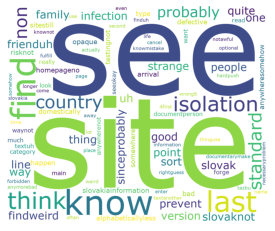

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

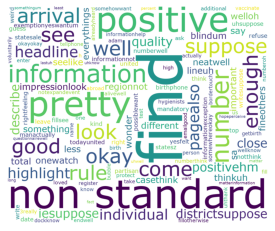

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,"So we've got 1,000.",get 1000,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
1,Uh.,uh,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
2,He's actually 1 to 2 minutes to get acquainted...,actually 1 2 minute get acquaint site,0.100000,0.000,0.000,1.000,0.0000,Neutral,None
3,So we see a headline on the page.,see headline page,0.000000,0.600,0.000,0.400,0.4588,Positive,None
4,Any stats a day?,stats day,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
...,...,...,...,...,...,...,...,...,...
268,To finish the vaccination of that.,finish vaccination,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
269,I guess he was the most understandable of the ...,guess understandable task,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
270,The worst tazbu will probably be found.,bad tazbu probably find,0.666667,0.353,0.412,0.235,-0.1280,Negative,None
271,"Uh, the information that from which countries ...",uh information country forbidden come slovakia...,0.000000,0.000,0.461,0.539,-0.7708,Negative,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

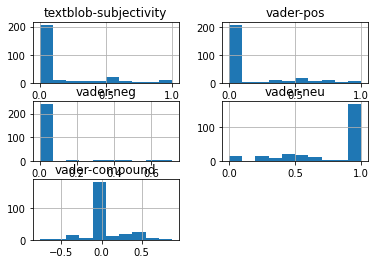

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

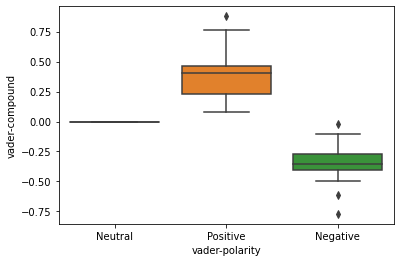

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

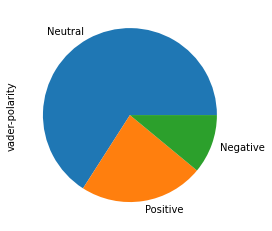

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
271,"Uh, the information that from which countries ...",uh information country forbidden come slovakia...,0.000000,0.000,0.461,0.539,-0.7708,Negative,None
9,How can we prevent infection that we should no...,prevent infection not see people not family fr...,0.000000,0.098,0.456,0.446,-0.6134,Negative,None
65,Less domestically bad type of arrival in Slova...,less domestically bad type arrival slovakia,0.366667,0.000,0.392,0.608,-0.4976,Negative,None
184,"6 4 it is actually cancelled, so it is no long...",6 4 actually cancel no longer necessary,0.550000,0.000,0.457,0.543,-0.4939,Negative,None
171,I guess I was entering some wrong.,guess enter wrong,0.900000,0.000,0.608,0.392,-0.4767,Negative,None
245,An awful lot of text.,awful lot text,1.000000,0.000,0.600,0.400,-0.4588,Negative,None
163,You pushed yourself away in the place of isola...,push away place isolation 4,0.000000,0.000,0.403,0.597,-0.4019,Negative,None
66,"With information isolation, I think he was som...",information isolation think somewhere homepage,0.000000,0.000,0.403,0.597,-0.4019,Negative,None
243,"The problem is on that page, isn't it?",problem page not,0.000000,0.000,0.574,0.426,-0.4019,Negative,None
164,"First and last name optional, I don't know.",first last name optional not know,0.200000,0.000,0.332,0.668,-0.3570,Negative,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
160,So in the event of a positive test to protect ...,event positive test protect loved one hygienis...,0.672727,0.591,0.0,0.409,0.8779,Positive,None
96,"That's where he actually sees the Rules, and I...",actually see rules think pretty well write,0.550000,0.655,0.0,0.345,0.7650,Positive,None
22,It looks pretty neat.,look pretty neat,1.000000,0.846,0.0,0.154,0.6705,Positive,None
256,Some of that information can be found pretty uh.,information find pretty uh,1.000000,0.733,0.0,0.267,0.6705,Positive,None
95,I think it's good as it's written right at the...,think good write right top man,0.545238,0.540,0.0,0.460,0.5719,Positive,None
11,What are we supposed to do when we're positive?,suppose positive,0.545455,0.783,0.0,0.217,0.5574,Positive,[Expectation]
39,"Uh, who has the most positive ones?",uh positive one,0.545455,0.643,0.0,0.357,0.5574,Positive,None
15,"Hm close to some qualities positive, i.e.",hm close quality positive ie,0.545455,0.474,0.0,0.526,0.5574,Positive,None
246,If I want to find something.,want find something,0.000000,0.811,0.0,0.189,0.5106,Positive,None
221,Good enough to be the higher number 3.,good enough high number 3,0.546667,0.583,0.0,0.417,0.4939,Positive,None
